In [10]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
from matplotlib.colors import LogNorm
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database


import jetson_configs as jcfg
from src.ml_helpers.make_ml_dataset import *

In [11]:
split_date     = jcfg.train_test_split
current_month  = jcfg.current_month
admin_level    = jcfg.admin_level
horizon        = jcfg.horizon

# Configure connection

In [12]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [13]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

# Construct the dataset

## Get the raw data

In [14]:
learn_df = make_ml_features(current_month, horizon, admin_level, sql_engine=engine)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_incidents', 'miss_malaria_cases', 'miss_measles_cases', 'miss_vegetation_cover_ndvi']


In [15]:
len(learn_df.index.get_level_values('date').unique())

116

## Construct a region-level arrivals table

In [16]:
sequences = learn_df['arrivals'].unstack(level='region') #.interpolate()
regions = sequences.columns

# Explore the distribution of arrivals

## Histogram

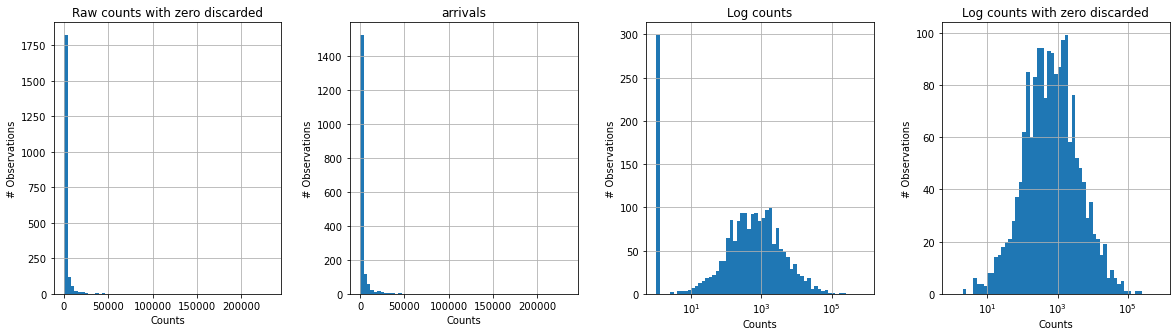

In [17]:
fig,ax = plt.subplots(1,4,figsize=[20,5])
plot_df = learn_df[['arrivals']].fillna(0)
bins = 10**(np.arange(0,6, .1))

plot_df.hist(bins=60, ax=ax[0])
plot_df[plot_df>0].hist(bins=60, ax=ax[1])
(1+plot_df).hist(bins=bins, ax=ax[2])
plot_df[plot_df>0].arrivals.hist(bins=bins, ax=ax[3])

ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].set_title("Raw counts")
ax[0].set_title("Raw counts with zero discarded")
ax[2].set_title("Log counts")
ax[3].set_title("Log counts with zero discarded")

for i in [0,1,2,3]:
    ax[i].set_xlabel("Counts")
    ax[i].set_ylabel("# Observations")

## Volume

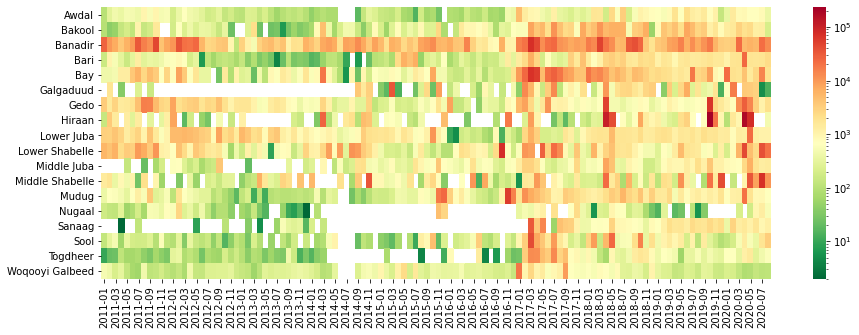

In [18]:
# Prepare plot dataframe
plot_df = learn_df['arrivals'].unstack(level='date')
plot_df.columns =  [str(c)[:7] for c in plot_df.columns]

# Prepare colorbar
min_arrivals, max_arrivals = plot_df.min().min(), plot_df.max().max()
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(min_arrivals)), 
                                             1+math.ceil(math.log10(max_arrivals)))]


fig, ax = plt.subplots(1,1, figsize=[15,5])
sns.heatmap(plot_df.astype(float), ax=ax, cmap = 'RdYlGn_r',
            norm=LogNorm(vmin=min_arrivals, vmax=max_arrivals), # Norm the colormap
            cbar_kws={"ticks": cbar_ticks}) # Add the right tix

ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig("figures/arrivals.png", bbox_inches="tight", dpi=100)

## Missing values

region
Lower Juba         0.000000
Banadir            0.000000
Bay                0.008621
Lower Shabelle     0.008621
Gedo               0.008621
Mudug              0.017241
Bari               0.017241
Woqooyi Galbeed    0.025862
Awdal              0.034483
Bakool             0.051724
Sool               0.094828
Middle Juba        0.189655
Middle Shabelle    0.189655
Togdheer           0.206897
Hiraan             0.353448
Nugaal             0.405172
Galgaduud          0.439655
Sanaag             0.525862
dtype: float64

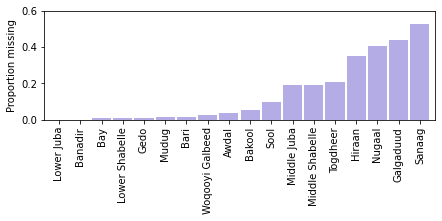

In [19]:
# What percent of regions are missing their dependent variable?
pct_missing_by_region = (1 - (sequences.count() / sequences.count().max())).sort_values()

fig, ax = plt.subplots(1,1,figsize=[7,2])
pct_missing_by_region.plot(kind='bar', width=0.9, ax=ax, ylim=[0,.6], color='slateblue', alpha=0.5)
ax.set_xlabel("")
ax.set_ylabel("Proportion missing")

plt.savefig("figures/pct_missing_target.png", dpi=100, bbox_inches="tight")

pct_missing_by_region

## Average, standard deviation, median

In [20]:
print ("The average number of arrivals is:   ", sequences.unstack().mean())
print("The standard deviation in arrivals is:", sequences.unstack().std())
print("The median number of arrivals is:     ", sequences.unstack().median())
print("The maximum number of arrivals is:     ", sequences.unstack().max())
print("\n")

The average number of arrivals is:    3036.294577976523
The standard deviation in arrivals is: 10151.053366444794
The median number of arrivals is:      657.0
The maximum number of arrivals is:      233924.0




In [11]:
#sequences.plot(subplots=True, figsize=[5,30])
#plt.show()

summary_stats = sequences.astype(float).describe().loc[['mean', 'std', '50%']].T.sort_values('mean')
summary_stats

,mean,std,50%
region,,,
Nugaal,474.347826,797.226088,194.0
Awdal,536.741071,698.246178,305.5
Woqooyi Galbeed,646.327434,2036.049402,273.0
Togdheer,930.836957,2389.155565,186.5
Middle Juba,1045.925532,1341.290008,621.5
Bari,1233.333333,2569.882776,326.5
Sool,1667.104762,5197.794634,230.0
Bakool,1724.663636,2383.505584,591.5
Sanaag,1964.036364,4615.043092,896.0


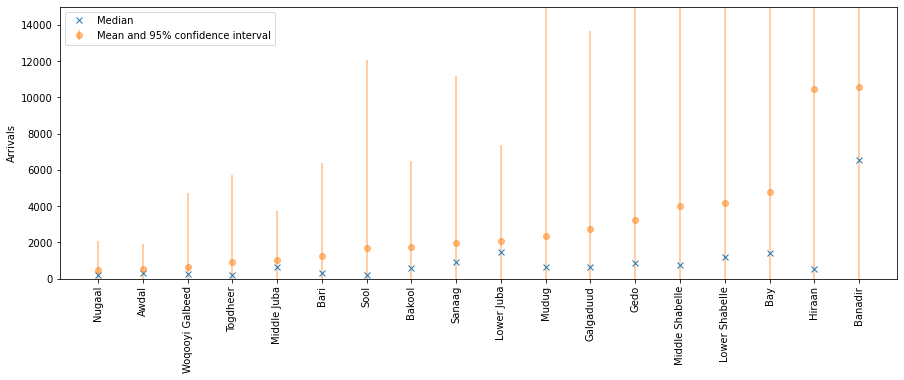

In [12]:
fig,ax=plt.subplots(1,1, figsize=[15,5])

summary_stats['50%'].plot(linestyle='None', marker='x', ax=ax, label='Median', rot=90)
ax.errorbar(x=summary_stats.index, y=summary_stats['mean'], yerr = 2*summary_stats['std'], alpha=0.5, linestyle='None', marker="o", 
            label = 'Mean and 95% confidence interval')
ax.legend(loc='upper left')
ax.set_xlabel("")
ax.set_ylabel("Arrivals")
ax.set_ylim(0,15000)

ax.set_xticks(range(0, len(summary_stats.index)))
ax.set_xticklabels(summary_stats.index)

plt.savefig("figures/avg_median_arrivals.png", dpi=100, bbox_inches="tight")

# Assess autocorrelation

In [13]:
arrivals_df  = learn_df[['arrivals']]

In [14]:
for lag in range(1,13):
    shift_df = learn_df[['arrivals']].sort_index(level=['region', 'date']).groupby(level='region').shift(lag)
    shift_df.rename(columns = {'arrivals': f'arrivals_lag{lag}'}, inplace=True)
    arrivals_df = arrivals_df.merge(shift_df, left_index=True, right_index=True)

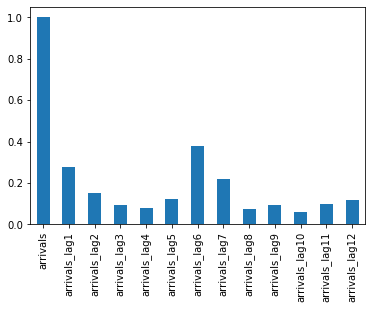

In [15]:
arrivals_df.corr()['arrivals'].plot(kind='bar')

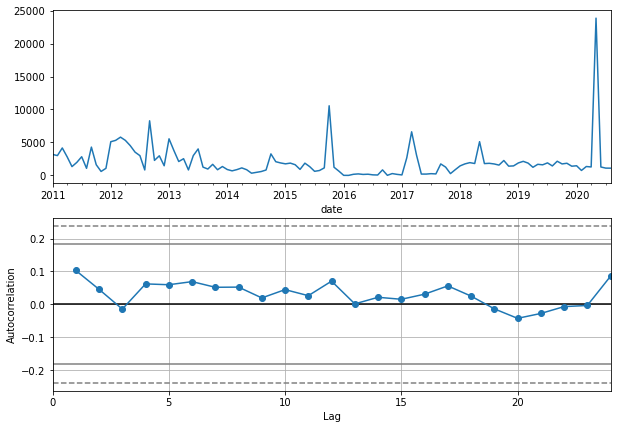

In [16]:
fig, ax = plt.subplots(2,1,figsize=[10,7])

# Option 1: Select a single region
regions=['Lower Juba']

# Option 2: Select regions with few missing values
#regions = pct_missing_by_region[pct_missing_by_region<0.1].index

for r in regions:
    sequences[r].plot(ax=ax[0])
    autocorrelation_plot(sequences[r].ffill(), ax=ax[1], marker="o")

    ax[1].set_xlim(0,24)

1     18.0
2     15.0
3     10.0
4      9.0
5      7.0
6      6.0
7      6.0
8      5.0
9      4.0
10     2.0
11     5.0
12     5.0
13     4.0
14    11.0
15     2.0
16     6.0
17     4.0
18     9.0
19     3.0
20     3.0
21     2.0
22     1.0
23     6.0
dtype: float64

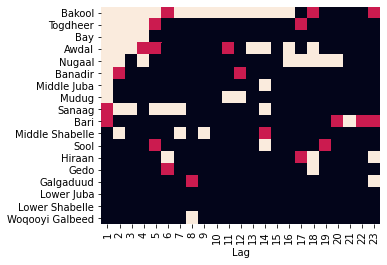

In [17]:
# Build a dataframe with the autocorrelations
autocorr_df = pd.DataFrame(columns = sequences.columns)

for r in sequences.columns:
    for lag in range(1,24):
        autocorr_df.loc[lag, r] = sequences[r].astype(float).autocorr(lag)

# Flag significant autocorrelations
sig95 = 1.959963984540054 / np.sqrt(sequences.shape[0])
sig99 = 2.5758293035489004 / np.sqrt(sequences.shape[0])

sig_autocorr_df = (autocorr_df > sig95).astype(float) + (autocorr_df > sig99).astype(float)

# Plot
fig,ax=plt.subplots(1,1,figsize=[5,4])
sig_autocorr_df = sig_autocorr_df.T.sort_values([1,2,3,4,5,6], ascending=False)
sns.heatmap(sig_autocorr_df, ax=ax, cbar=False)
ax.set_ylabel("")
ax.set_xlabel("Lag")
plt.savefig("figures/autocorrelation.png", dpi=100, bbox_inches="tight")

sig_autocorr_df.sum()

In [18]:
print ("On average, the change in arrivals is:", (sequences - sequences.shift(1)).unstack().mean())
print("The median change in arrivals is:    ", (sequences - sequences.shift(1)).unstack().median())
print("The standard deviation in arrivals is:    ", (sequences - sequences.shift(1)).unstack().std())
print("\n")
print("The median of the absolute value of the change in arrivals is:", (np.abs(sequences - sequences.shift(1))).unstack().median())
print ("On average, the absolute value of the change in arrivals is: ", (np.abs(sequences - sequences.shift(1))).unstack().mean())

On average, the change in arrivals is: 91.08303249097473
The median change in arrivals is:     -12.0
The standard deviation in arrivals is:     12398.544648250727


The median of the absolute value of the change in arrivals is: 412.0
On average, the absolute value of the change in arrivals is:  3175.9398315282792
